In [ ]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the grpd excel file
grpd_df = pd.read_excel("Datasets/grpd.xlsx")
print(grpd_df.head(5))

   INCNUMBER OFFENSECODE Beat__ Service_Area MICRCODE     Offense_Description  \
0  21-000231        9310     N8        North    Local                   Local   
1  21-000111        9571     N3        North    Local                   Local   
2  21-000001        9332     W4         West    Local                   Local   
3  21-000235        9141     E8         East    Local                   Local   
4  21-000235        2203     E8         East    22001  Burglary, Forced Entry   

                   NIBRS_Maping           NIBRS_Category  \
0                         Local                    Local   
1                         Local                    Local   
2                         Local                    Local   
3                         Local                    Local   
4  Burglary/Breaking & Entering  Crimes Against Property   

                      NIBRS_GRP                           OFFENSETITLE  \
0                         Local             Family Or Domestic Trouble   
1   

In [ ]:
# Load the zillow excel file
zillow_df = pd.read_excel("Datasets/zillow_real_estate_data.xlsx")
zillow_df.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Value
0,269973,512,Creston,neighborhood,MI,MI,Grand Rapids,"Grand Rapids-Kentwood, MI",Kent County,2010-01-31,92996.665033
1,269995,889,Garfield Park,neighborhood,MI,MI,Grand Rapids,"Grand Rapids-Kentwood, MI",Kent County,2010-01-31,46774.077332
2,270077,964,West Grand,neighborhood,MI,MI,Grand Rapids,"Grand Rapids-Kentwood, MI",Kent County,2010-01-31,60029.955029
3,270082,1495,Westside Connection,neighborhood,MI,MI,Grand Rapids,"Grand Rapids-Kentwood, MI",Kent County,2010-01-31,105290.353089
4,274679,1650,Northeast,neighborhood,MI,MI,Grand Rapids,"Grand Rapids-Kentwood, MI",Kent County,2010-01-31,109871.595075


In [ ]:
# Check the no of rows and columns for both datasets
grpd_df.shape, zillow_df.shape

((257815, 20), (6006, 11))

In [ ]:
# Check for missing values in grpd dataset
grpd_df.isna().sum()

INCNUMBER                          0
OFFENSECODE                        0
Beat__                             0
Service_Area                       0
MICRCODE                           0
Offense_Description                0
NIBRS_Maping                       0
NIBRS_Category                     0
NIBRS_GRP                          0
OFFENSETITLE                       0
DATEOFOFFENSE                      2
Day_of_the_Week                    0
WEAPONTYPE                         0
BLOCK_ADDRESS__INCIDENT_LOCATIO    0
Month                              0
ObjectId                           0
lat                                0
long                               0
Region                             0
RegionName                         0
dtype: int64

In [7]:
grpd_df['Service_Area'] = grpd_df['Service_Area'].str.strip().str.title()

# Drop rows where Service Area is missing 
grpd_df = grpd_df[grpd_df['Service_Area'].notna() & (grpd_df['Service_Area'] != "")]

In [ ]:
# Check for missing values in zillow dataset
zillow_df.isna().sum()

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       0
State           0
City            0
Metro           0
CountyName      0
Date            0
Value         164
dtype: int64

In [ ]:
# Drop the missing values
zillow_df.dropna(subset=['Value'], inplace=True)

In [ ]:
# Map Regions in grpd dataset to relevant values in zillow dataset. This is to ensure we've same region names in both datasets
zillow_to_grpd_region_map = {
    "Alger Heights": "Alger Heights",
    "Baxter": "Baxter",
    "Belknap Lookout": "Belknap Lookout",
    "Black Hills": "Black Hills",
    "Cherry Run": None,
    "Creston": "Creston",
    "East Hills": "East Hills",
    "Eastgate": "Eastgate",
    "Eastown": "Eastown",
    "Fuller Avenue": None,
    "Fulton Heights": "Fulton Heights",
    "Garfield Park": "Garfield Park",
    "Heartside": "Oldtown-Heartside",
    "Heritage Hill": "Heritage Hill",
    "Highland Park": "Highland Park",
    "John Ball Park": "John Ball Park",
    "Ken-O-Sha Park": "ken-O-Sha Park",
    "Madison Area": None,
    "Michigan Oaks": "Michigan Oaks",
    "Midtown": "Midtown",
    "Millbrook": "Millbrook Community Bridgeworks",
    "Northeast": "Northeast",
    "Oakdale": None,
    "Ridgemoor": "Ridgemoor",
    "Roosevelt Park": "Roosevelt Park",
    "Shangrai-La": "Shangrai-La",
    "Shawnee Park": "Shawnee Park",
    "South East Community": "Southeast Community",
    "South East End": "Southeast End",
    "South Hill": None,
    "Southwest": "Southwest",
    "West Grand": "West Grand",
    "Westside Connection": "Richmond-Oakleigh" 
}

zillow_df["RegionName"] = zillow_df["RegionName"].map(zillow_to_grpd_region_map)

<h4><b>Task 1: How Crime Trends and Real Estate Values Evolved in Grand Rapids</b></h4>

In [11]:
# Convert offense date to datetime and extract month
grpd_df["DATEOFOFFENSE"] = pd.to_datetime(grpd_df["DATEOFOFFENSE"], errors="coerce")
grpd_df["Month"] = grpd_df["DATEOFOFFENSE"].dt.to_period("M").dt.to_timestamp()

# Group by month to get crime count
monthly_crime_counts = grpd_df.groupby("Month").size().reset_index(name="CrimeCount")

monthly_crime_counts

zillow_df["Date"] = pd.to_datetime(zillow_df["Date"])
zillow_df = zillow_df[zillow_df["Date"] >= "2021-01-01"]
zillow_df["Month"] = zillow_df["Date"].dt.to_period("M").dt.to_timestamp()

# Average price per month across neighborhoods
monthly_avg_price = (
    zillow_df.groupby("Month")["Value"]
    .mean()
    .reset_index()
    .rename(columns={"Value": "AveragePrice"})
)

task1_df = pd.merge(monthly_crime_counts, monthly_avg_price, on="Month", how="inner")

/var/folders/s4/_s7bt8m12cs4j6d1lwvcj7_c0000gn/T/ipykernel_30741/3556675504.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  grpd_df["Month"] = grpd_df["DATEOFOFFENSE"].dt.to_period("M").dt.to_timestamp()


Check for any skewness in average property prices over time

Skewness in average monthly price: -0.44


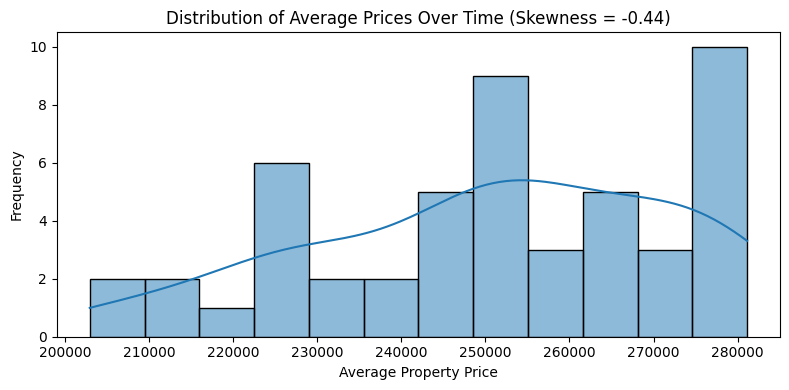

In [12]:
# Calculate skewness
time_skewness = skew(monthly_avg_price['AveragePrice'])
print(f"Skewness in average monthly price: {time_skewness:.2f}")

# Plot histogram
plt.figure(figsize=(8, 4))
sns.histplot(monthly_avg_price['AveragePrice'], kde=True, bins=12)
plt.title(f"Distribution of Average Prices Over Time (Skewness = {time_skewness:.2f})")
plt.xlabel("Average Property Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

<h4>
<b>Task 2: How do crime rates vary across different neighborhoods in Grand Rapids?</b><br>
<b>Task 4: How are property values distributed in relation to crime hotspots?</b>
</h4>

In [13]:
# Group by Region and count number of crimes
crime_counts = grpd_df.groupby("RegionName").size().reset_index(name="Crime Count")

# Compute average home value per region
avg_prices = zillow_df.groupby("RegionName")["Value"].mean().reset_index(name="Average_Price")

# Merge Both Datasets on Region
task2_df = pd.merge(crime_counts, avg_prices, on="RegionName", how="left")
task2_df

,RegionName,Crime Count,Average_Price
0,Alger Heights,3698,242775.050611
1,Baxter,5538,184561.832776
2,Belknap Lookout,11596,222563.130231
3,Black Hills,1888,159628.706937
4,Creston,13394,245983.953168
5,Downtown,11066,NaN
6,East Hills,2631,271059.288895
7,Eastern-Burton,1496,NaN
8,Eastgate,559,300380.618891
9,Eastown,3914,307528.753427


Similarly, check the skewness for average property prices over region

Skewness in average monthly region price: 0.02


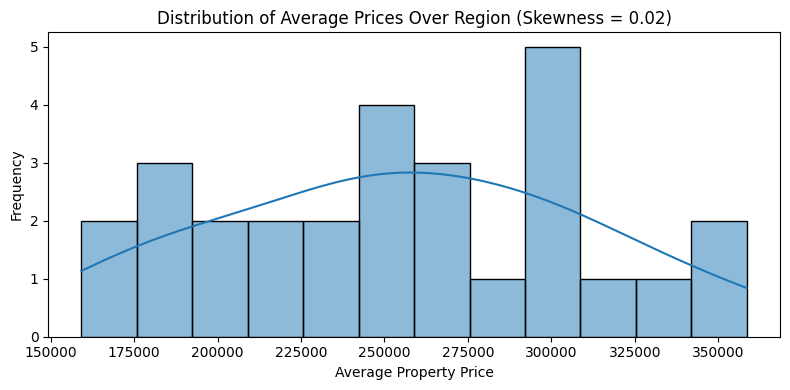

In [14]:
# Calculate skewness
time_skewness = skew(avg_prices['Average_Price'])
print(f"Skewness in average monthly region price: {time_skewness:.2f}")

# Plot histogram
plt.figure(figsize=(8, 4))
sns.histplot(avg_prices['Average_Price'], kde=True, bins=12)
plt.title(f"Distribution of Average Prices Over Region (Skewness = {time_skewness:.2f})")
plt.xlabel("Average Property Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

<h4><b>Task 5: Are there specific types of crimes that have a more significant impact on real estate prices?</b></h4>

In [ ]:
# Function to categorize crimes
def map_crime_category(offense):
    offense = offense.lower()
    if any(keyword in offense for keyword in ['assault', 'homicide', 'robbery', 'manslaughter']):
        return 'Violent Crime'
    elif any(keyword in offense for keyword in ['burglary', 'theft', 'larceny', 'arson']):
        return 'Property Crime'
    elif 'drug' in offense:
        return 'Drug Offense'
    elif any(keyword in offense for keyword in ['dui', 'disorderly', 'drunkenness']):
        return 'Public Order Offense'
    elif any(keyword in offense for keyword in ['fraud', 'embezzlement', 'counterfeit']):
        return 'Fraud / White Collar'
    elif 'sex' in offense or 'prostitution' in offense:
        return 'Sex Offense'
    else:
        return 'Other'

grpd_df['CrimeCategory'] = grpd_df['OFFENSETITLE'].apply(map_crime_category)

In [16]:
# Group by Region, Month, and CrimeCategory
crime_agg = grpd_df.groupby(['Region', 'Month', 'CrimeCategory']).size().reset_index(name='CrimeCount')

price_by_region_month = zillow_df.groupby(['RegionName', 'Month'])['Value'].mean().reset_index(name='AveragePrice')

# Merge crime and price data on Region and YearMonth
merged_df = pd.merge(
    crime_agg,
    price_by_region_month,
    left_on=['Region', 'Month'],
    right_on=['RegionName', 'Month'],
    how='inner'
)

# Drop redundant RegionName column
task4_df = merged_df.drop(columns=['RegionName'])
task4_df

,Region,Month,CrimeCategory,CrimeCount,AveragePrice
0,Alger Heights,2021-01-01,Drug Offense,2,192054.173792
1,Alger Heights,2021-01-01,Other,49,192054.173792
2,Alger Heights,2021-01-01,Property Crime,14,192054.173792
3,Alger Heights,2021-01-01,Sex Offense,1,192054.173792
4,Alger Heights,2021-01-01,Violent Crime,3,192054.173792
...,...,...,...,...,...
5530,ken-O-Sha Park,2024-12-01,Other,110,289045.102359
5531,ken-O-Sha Park,2024-12-01,Property Crime,17,289045.102359
5532,ken-O-Sha Park,2024-12-01,Sex Offense,3,289045.102359
5533,ken-O-Sha Park,2024-12-01,Violent Crime,12,289045.102359


<h4><b>Task 6: Which Grand Rapids neighborhoods show signs of stability and long-term investment potential based on crime rates and property value trends?</b></h4>

In [ ]:
# Group by RegionName and Date
region_monthly = zillow_df.groupby(['RegionName', 'Date'])['Value'].mean().reset_index()

# Calculate average value
region_summary = region_monthly.groupby('RegionName').agg({
    'Value': ['mean', 'std', lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0]]
}).reset_index()

region_summary.columns = ['Region', 'AvgPrice', 'PriceVolatility', 'GrowthRate']

crime_summary = grpd_df.groupby('Region').size().reset_index(name='CrimeCount')

# Merge both crime and region summaries
task6_df = region_summary.merge(crime_summary, on='Region')
task6_df

,Region,AvgPrice,PriceVolatility,GrowthRate,CrimeCount
0,Alger Heights,242775.050611,21664.645581,0.420318,3698
1,Baxter,184561.832776,17382.428068,0.435028,5538
2,Belknap Lookout,222563.130231,19067.754970,0.350661,11596
3,Black Hills,159628.706937,18845.934753,0.545459,1888
4,Creston,245983.953168,21041.963880,0.381888,13394
5,East Hills,271059.288895,22746.212520,0.347519,2631
6,Eastgate,300380.618891,27076.915862,0.421110,559
7,Eastown,307528.753427,27611.138834,0.384356,3914
8,Fulton Heights,292176.862211,26938.216602,0.405470,1565
9,Garfield Park,197058.300981,14701.308970,0.356346,25657


In [ ]:
# Export all the outputs to single excel file with multiple sheets
with pd.ExcelWriter('tableau_output.xlsx') as writer:
    task1_df.to_excel(writer, sheet_name='Task 1', index=False)
    task2_df.to_excel(writer, sheet_name='Task 2', index=False)
    task4_df.to_excel(writer, sheet_name='Task 4', index=False)
    task6_df.to_excel(writer, sheet_name='Task 6', index=False)